# Vehicle Detection Project

In this project we implement a pipeline to detect vehicles in images. We perform the following steps:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

## Feature extraction

### HOG

We start by reading all the vehicle and non-vehicle images. These images come from the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video. Here is an example of one of each of the vehicle and non-vehicle classes:

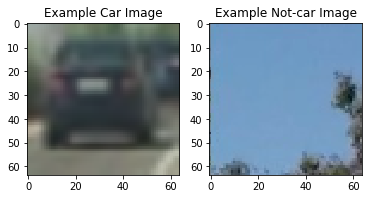

In [2]:
cars = glob.glob('vehicles\*\*')
notcars = glob.glob('non-vehicles\*\*')

# Plot the examples
img1 = cv2.imread(cars[0])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(notcars[0])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)


fig = plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.title('Example Car Image')

plt.subplot(122)
plt.imshow(img2)
plt.title('Example Not-car Image')

I then explored different color spaces and different `skimage.hog()` parameters (orientations, pixels_per_cell, and cells_per_block). I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using HOG parameters of orientations=12, pixels_per_cell=(4, 4) and cells_per_block=(2, 2):

In [75]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

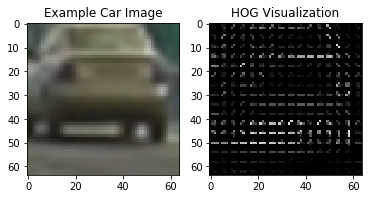

In [76]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = cv2.imread(cars[25])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Define HOG parameters
orient = 12
pix_per_cell = 4
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

The HOG visualization is a representation that shows the dominant gradient direction within each cell with brightness corresponding to the strength of gradients in that cell. 

### Spatial binning of Color

I also implemented spatial binning feature extraction.

In [77]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [78]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [79]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [80]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [380, None]

### Parameter selection

I tried various combinations of parameters, but I am getting the best results using the YCrCb color space, 11 HOG orientations, 8 HOG pixels per cells, and 2 cells per block. I extract the HOG features for all the color channels. In addition, I perform a spatial binning extraction with 16 histogram bins and size (16 x 16). 





## Classifier

We are now ready to train a classifier. 

In [81]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)



In [82]:
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

First we define a labels vector based on the two features lists : if the image is a vehicle, the label is 1, and 0 otherwise. Then, we stack oand scale our feature vectors, using  `sklearn.StandardScaler()` to normalize the data to 0 mean and unit variance. The next step is to shuffle and split the data into training and test sets, using `sklearn.train_test_split()`. Finally we use the training data to train a linear Support Vector Machine classifier. The penalty parameter C of the LinearSVC is optimized using grid search. We get a very high test accuracy at 98.9%

In [83]:
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [84]:
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [85]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [86]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# use grid search to optimize the cross validation accuracy
parameters = { 'C':[1,5,7.5,10]}
clf = GridSearchCV(svc, parameters,n_jobs=-1)
clf.fit(X_train, y_train)
print('Test Accuracy of SVC = ', clf.score(X_test, y_test))

Test Accuracy of SVC =  0.989617324236


## Sliding window search - hog sub-sampling

We now implement a window search in order to use our SVM classifier on small parts of the image. We write a function called `find_cars` that implements  hog sub-sampling in order to extract features and make predictions. The function returns a list of bounding boxes corresponding to the location of detected cars. 

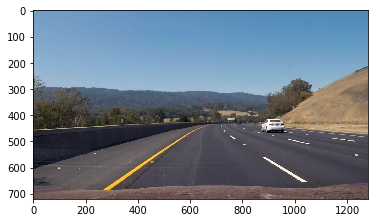

In [87]:
# load a test image
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [88]:
# we will use this function to draw boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In order to avoid False Positive in the sky or in the trees, we limit the search window to the lower part of the image.

In [89]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
        
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                if xbox_left>400:
                    boxes.append(box)
                
    return boxes, draw_img
    


The following image gives an example of detection:

In [90]:
ystart = 400
ystop = 656
scale = 1.4

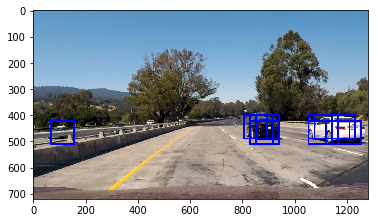

In [91]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

box_list,draw_img = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins)

plt.imshow(draw_img)

In order to limit the number of false positives, we build a heatmap where each pixel gets a value corresponding to the number of detected boxes it is part of. We then define a threshold and accept only values above this threshold as detected areas. A further improvment would be to use the information from previous frames in order to eliminate false positive, as a car can't just appear in the middle of the image if it wasn"t there in previous frames

In [92]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [93]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

In [94]:
THRESHOLD = 2

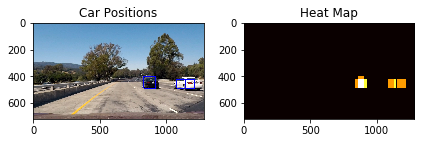

In [95]:
from scipy.ndimage.measurements import label

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,THRESHOLD)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Apply the pipeline to a video

In order to improve the detection and limit the number of false positive, we record the detected boxes for the last N frames. When we detect cars on a new video frame, we add to the image the previous detection and we build the corresponding heat map, with a threshold value of 5. In that way, it is required that a detection is found at or near the same position in several subsequent frames.

In [96]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [97]:
video = VideoFileClip("test_video.mp4")

In [108]:
NB_FRAMES = 10

class BBoxes:
    
    def __init__(self):
        self.box_lists = []
        
    def add_box_list(self,box_list):
        self.box_lists.append(box_list)
        if len(self.box_lists)>NB_FRAMES:
            self.box_lists.pop(0)
        
    def get_boxes(self):
        boxes = []
        for box_list in self.box_lists:
            for box in box_list:
                boxes.append(box)
        return boxes

In [112]:
THRESHOLD = 5
bboxes = BBoxes()

In [110]:
def process_image(image):
    global bboxes
    
    # find the cars using the classifier
    new_box_list,out_img = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    bboxes.add_box_list(new_box_list)
    # get the boxes from the previous frames
    box_list = bboxes.get_boxes()
    
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,THRESHOLD)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [113]:
project_video = VideoFileClip("project_video.mp4")
result_video = project_video.fl_image(process_image)
%time result_video.write_videofile("project_output3.mp4", audio=False)

[MoviePy] >>>> Building video project_output3.mp4
[MoviePy] Writing video project_output3.mp4



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:08<00:00,  2.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output3.mp4 

Wall time: 9min 9s


# Discussion

Recording the position of detection in the previous frames was a huge improvment and the detection is now performing quite well on the project video.

I think that the classifier that I am using tends to overfit the dataset, due to the high number of similar images coming from a same video sequence. I tried to use a subsample of the dataset to remove the GTI images but in that case the dataset was too small to get good results. 

Obviously, training with more data could also help the classifier to generalize better. I used a simple Linear Support Vector Machine, but we could choose other machine learning algorithms such as Random Forest, Extreme Gradient Boosting... Utimately, we could use ensembling techniques to build a stronger model by combining several models. I tried the Random Forest approach but the time taken to build the video became too important. It seems important to use a model with a reasonable computation time so that we can use it to detect cars in real time.